End-to-End OCR

In [1]:
import tensorflow as tf
import numpy as np
import PIL
import cv2
import keras_ocr

print(tf.__version__)
print(np.__version__)
print(PIL.__version__)
print(cv2.__version__)
print(keras_ocr.__version__)

2.6.0
1.21.4
8.3.2
4.5.3
0.8.8


keras OCR의 Detector class

데이터 다운로드

In [2]:
from keras_ocr.detection import Detector

detector = Detector()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


In [3]:
SAMPLE_IMG_PATH = 'sample.jpg'

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


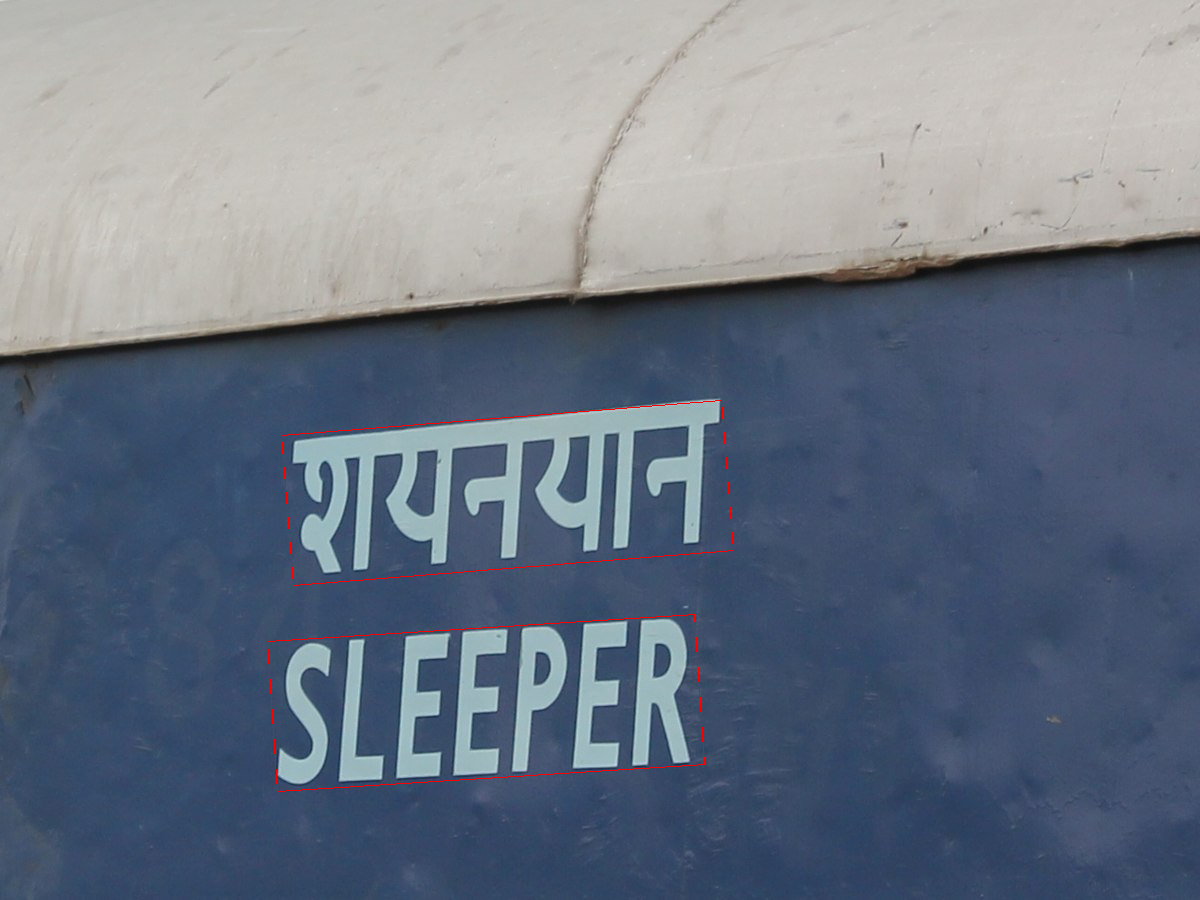

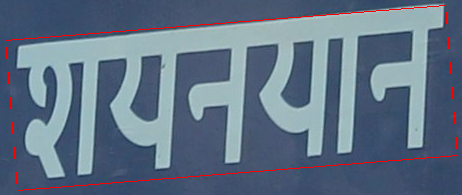

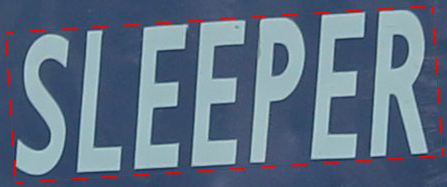

In [4]:
import keras_ocr
from PIL import Image, ImageDraw
import numpy as np

def detect_text(img_path):
    # Initialize the keras-ocr detector
    detector = keras_ocr.detection.Detector()
    
    # Load and preprocess the image
    img_pil = Image.open(img_path).convert('RGB')  # Convert to RGB if not already
    img_np = np.array(img_pil)  # Convert to numpy array
    img_batch = np.expand_dims(img_np, axis=0)  # Expand dimensions to match batch size
    
    # Detect text in the image
    ocr_result = detector.detect(img_batch)  # List of detections for the batch
    text_results = ocr_result[0]  # First result from the batch (our single image)
    
    # Draw detected regions and crop text
    img_draw = ImageDraw.Draw(img_pil)
    cropped_imgs = []
    for text_result in text_results:
        # Draw polygon around detected text
        img_draw.polygon([tuple(coord) for coord in text_result], outline='red')
        
        # Get bounding box for the detected text
        x_min = int(text_result[:, 0].min()) - 5
        x_max = int(text_result[:, 0].max()) + 5
        y_min = int(text_result[:, 1].min()) - 5
        y_max = int(text_result[:, 1].max()) + 5
        word_box = [x_min, y_min, x_max, y_max]
        
        # Crop the text region and store it
        cropped_imgs.append(img_pil.crop(word_box))
    
#     # cropped_imgs 에러가 나서
#     # cropped_imgs가 비어있는지 확인
#     if not cropped_imgs:
#         print("텍스트 영역이 감지되지 않았습니다. cropped_imgs 리스트가 비어 있습니다.")
#     else:
#         for i, cropped in enumerate(cropped_imgs):
#             print(f"잘라낸 텍스트 영역 {i + 1} 표시 중")
#             cropped.show()
        
    return img_pil, cropped_imgs

# Example usage:
image_path = 'sample.jpg'
result_img, cropped_text_regions = detect_text(image_path)

# Show the result image
result_img.show()

# Display cropped text regions
for i, cropped in enumerate(cropped_text_regions):
    cropped.show()


단어의 영역을 잘라오도록 함

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


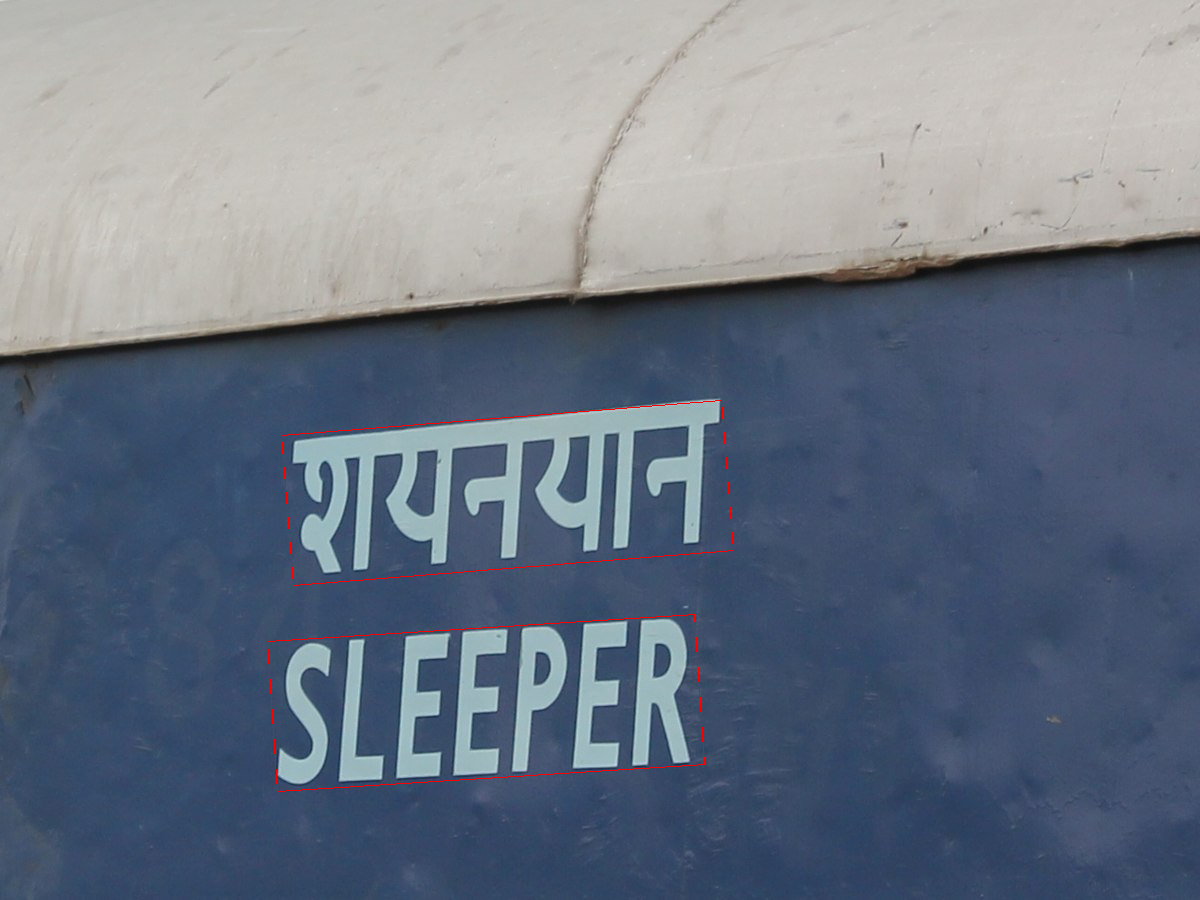

In [5]:
img_pil, cropped_img = detect_text(SAMPLE_IMG_PATH)
display(img_pil)

Recognition model로 인식하는 함수 생성

Looking for /aiffel/.keras-ocr/crnn_kurapan.h5
Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5


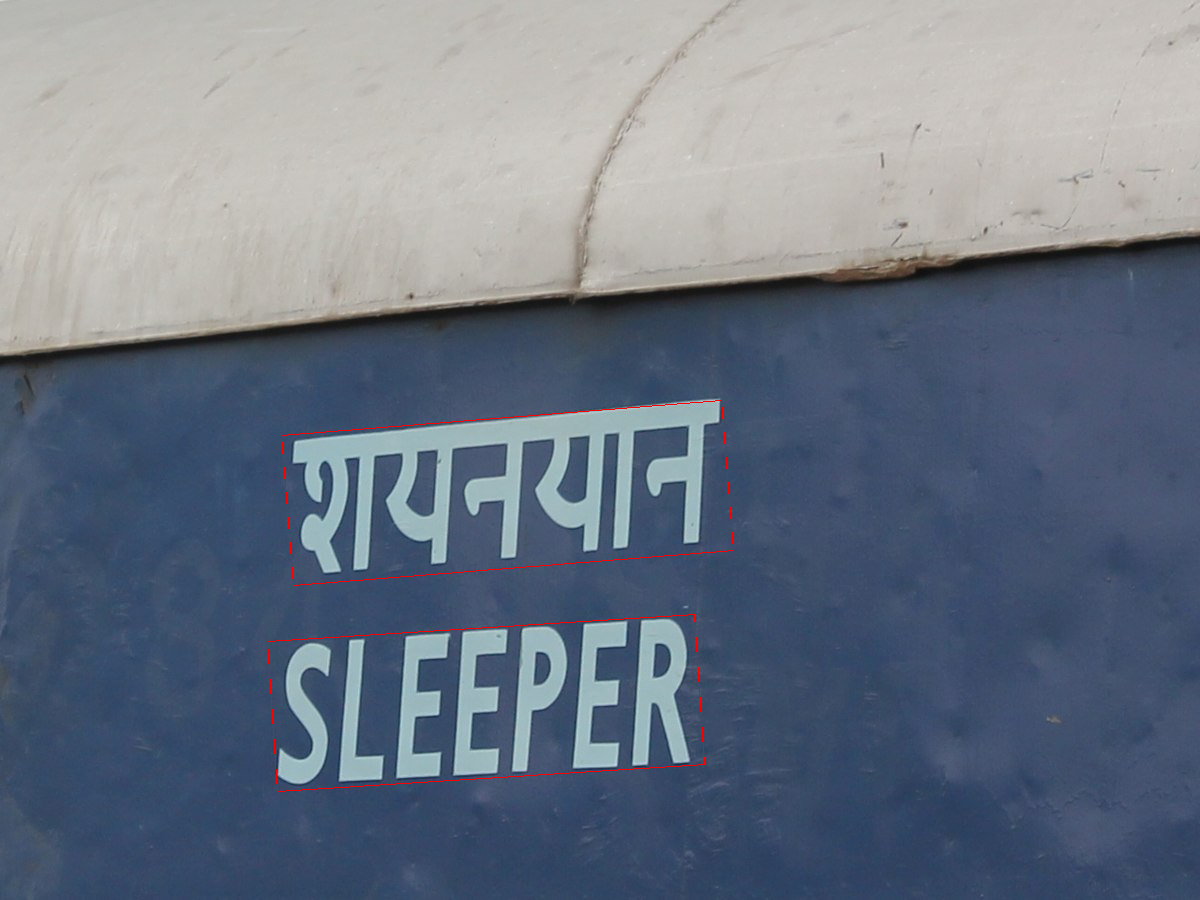

NotImplementedError: Unsupported mode: fit

In [11]:
# Define the function to recognize an image
from keras_ocr.tools import read_and_fit

def recognize_img(pil_img, recognition_model, input_img_size=(100, 32)):
    """
    Recognize text from a single PIL image using the recognition model.

    Args:
        pil_img: PIL image of the cropped text region.
        recognition_model: Pre-trained keras-ocr recognition model.
        input_img_size: Tuple of (width, height) for resizing the image.

    Returns:
        recognized_text: The recognized text from the image.
    """
    # Convert PIL image to numpy array
    img_array = np.array(pil_img).astype(np.float32) / 255.0

    # Ensure the image fits the expected dimensions
    img_array = read_and_fit(
        filepath_or_array=img_array,
        width=input_img_size[0],
        height=input_img_size[1],
        mode="fit",
    )

    # Recognize text using the recognition model
    predictions = recognition_model.recognize([img_array])  # Expecting a list of arrays
    recognized_text = predictions[0] if predictions else ""  # Get first prediction

    return recognized_text

# def recognize_img(pil_img, input_img_size=(100, 32), recognition_model=None):
#     # Convert PIL image to numpy array
#     img_array = np.array(pil_img).astype(np.float32) / 255.0

#     # Ensure the array has the correct shape (H, W, C)
#     if len(img_array.shape) == 2:  # If grayscale, add a channel dimension
#         img_array = np.expand_dims(img_array, axis=-1)

#     # Perform inference using the recognition model
#     predictions = recognition_model.recognize([img_array])  # Use 'recognize' instead of 'predict'
#     recognized_text = predictions[0] if predictions else ""  # Take the first prediction if available

#     return recognized_text

def decode_predictions(predictions):
    # Assuming the model outputs character probabilities,
    # use argmax to select the most likely character for each timestep.
    char_indices = np.argmax(predictions, axis=-1)[0]  # Get most likely indices
    recognized_text = ''.join([CHARACTER_SET[i] for i in char_indices if i < len(CHARACTER_SET)])
    return recognized_text

# Define the character set your model supports
CHARACTER_SET = "abcdefghijklmnopqrstuvwxyz0123456789"  # Example character set

# Load the pre-trained recognition model
recognition_model = keras_ocr.recognition.Recognizer()

# Example usage: Detect and recognize text
image_path = 'sample.jpg'
result_img, cropped_imgs = detect_text(image_path)  # Detect text regions

# Display the result image
result_img.show()

# Recognize text from cropped images
for i, cropped in enumerate(cropped_imgs):
    recognized_text = recognize_img(cropped, recognition_model=recognition_model)
    print(f"Cropped Image {i + 1}: {recognized_text}")
    
# # Example usage with cropped images
# cropped_imgs = [...]  # Replace with the list of cropped PIL images
# recognition_model = ...  # Load your pre-trained recognition model

# for i, _img in enumerate(cropped_imgs):
#     recognized_text = recognize_img(_img, recognition_model=recognition_model)
#     print(f"Cropped Image {i + 1}: {recognized_text}")

